In [1]:
# import pandas as pd

# # 加载 Excel 文件
# excel_path = './beiyou_excel/chaoyang_retrospective_233.xlsx'
# labels_df = pd.read_excel(excel_path)

# # 查看标签数据框架
# print(labels_df.head())

(512, 512)
[[7.5231638e-37 4.1386000e-15 1.3242035e-13 ... 5.0483202e-04
  4.9985462e-04 4.8986345e-04]
 [1.6668663e-14 2.7895402e-13 1.6726687e-12 ... 5.3072593e-04
  5.2554440e-04 5.0992717e-04]
 [5.3339722e-13 2.6542386e-12 8.9265288e-12 ... 5.5767159e-04
  5.4676417e-04 5.3072593e-04]
 ...
 [2.2924140e-03 2.3788379e-03 2.4678514e-03 ... 5.2731574e-02
  5.1903136e-02 5.1085170e-02]
 [2.2756967e-03 2.3616203e-03 2.4319324e-03 ... 5.2103631e-02
  5.1283136e-02 5.0472952e-02]
 [2.2420385e-03 2.3094960e-03 2.3961582e-03 ... 5.1481716e-02
  5.0669048e-02 4.9866676e-02]]


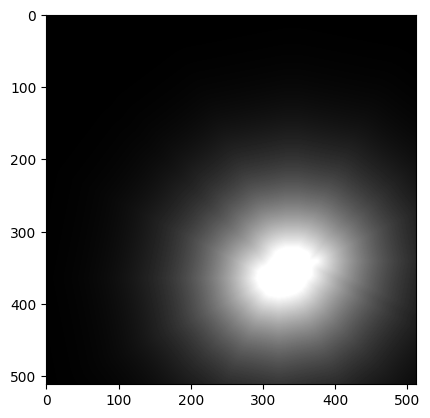

In [2]:
import os
from load_img import load_dcm, load_nii 

# dir = "./chaoyang_huigu/BAILIANDI RCC"
dir = "./chaoyang_huigu/BAILIANDI RMLO"

img_nib = load_nii(os.path.join(dir, "1.nii.gz"))
print(img_nib.shape)
print(img_nib)
# #查看img_nib中最大值，以及他的位置
# print(np.max(img_nib))
# print(np.where(img_nib == np.max(img_nib)))

# img_dcm = pydicom.dcmread(os.path.join(dir, "ser97311img00002.dcm"))
# img_dcm = load_dcm(os.path.join(dir, "ser97311img00001.dcm"))
# print(img_dcm.shape)
# print(img_dcm)

# # 查看 DICOM 图像
import matplotlib.pyplot as plt
# plt.imshow(img_dcm, cmap='gray')
plt.imshow(img_nib, cmap='gray')




In [3]:
import pandas as pd
from process_data import process_images_for_patients

def load_labels(excel_path):
    labels_df = pd.read_excel(excel_path)
    return labels_df


base_path = './chaoyang_huigu'  # 图像数据的根目录
target_size = (512, 512)  # 目标图像尺寸

patient_images = process_images_for_patients(base_path, target_size)



d:\miniconda3\envs\mg\lib\site-packages\pydicom\charset.py:754: UserWarning: Unknown encoding 'ISO 2022 IR 165' - using default encoding instead
  _warn_about_invalid_encoding(encoding)


In [ ]:
# 加载标签数据
excel_path = './beiyou_excel/chaoyang_retrospective_233.xlsx'  # 包含病人姓名和标签的Excel文件路径
labels_df = load_labels(excel_path)
# 补全标签并构建 images_with_labels 列表
images_with_labels = []
labels = []
for i, patient_input in enumerate(patient_images):
    label = labels_df.iloc[i]['N分期']  # 按顺序获取对应的标签

    # 如果标签为 NaN，则用均值填充
    if pd.isna(label):
        label = 1.0

    images_with_labels.append((patient_input, label))
    labels.append(label)

# # 输出处理后的标签
# for i, (_, label) in enumerate(images_with_labels):
#     print(f"第 {i+1} 项标签: {label}")
# print(labels)

[1.0, 0.0, 3.0, 0.0, 0.0, 2.0, 0.0, 3.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 3.0, 0.0, 1.0, 0.0, 0.0, 1.0, 3.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 0.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 3.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 3.0, 0.0, 0.0, 3.0, 0.0, 1.0, 2.0, 0.0, 3.0, 0.0, 1.0, 1.0, 3.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 3.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0,

In [25]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms

from dataset import ImageDataset

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    # transforms.RandomVerticalFlip(),    # 随机垂直翻转
    transforms.RandomRotation(20),      # 随机旋转 
    transforms.RandomResizedCrop(512, scale=(0.8, 1.0)),  # 随机裁剪并调整到 512x512
    transforms.Normalize([0.5], [0.5]),  # 归一化到 [-1, 1]
])

# 验证集保持原始数据
val_transform = transforms.Compose([
    transforms.Normalize([0.5], [0.5]),  # 与训练集一致的归一化
])


# 创建数据集实例
full_dataset = ImageDataset(images_with_labels)

# 使用 random_split 分割数据集
train_size = int(0.8 * len(full_dataset))  # 80% 训练集
val_size = len(full_dataset) - train_size  # 20% 验证集
train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

# 为分割后的子集添加数据增强
train_subset.dataset.transform = train_transform
val_subset.dataset.transform = val_transform

# 创建 DataLoader
train_loader = DataLoader(train_subset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_subset, batch_size=4, shuffle=False, num_workers=0)

# 检查训练集的第一个批次
# for inputs, labels in train_loader:
#     print(f"输入张量形状: {inputs}")
#     print(f"标签张量形状: {labels}")
#     break

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# 训练函数
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()  # 设置模型为训练模式
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        # 将数据移动到 GPU 或 CPU
        inputs, labels = inputs.to(device), labels.to(device)

        # with open("debug_log.txt", "a") as f:
        #     f.write(f"Inputs shape: {inputs.shape}\n")
        #     f.write(f"Labels shape: {labels.shape}\n")
        #     f.write(f"Inputs values: {inputs}\n")
        #     f.write(f"Labels values: {labels}\n")

        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 反向传播与优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 记录损失
        running_loss += loss.item()

        # 计算准确率
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

# 验证函数
def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()  # 设置模型为评估模式
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            # 将数据移动到 GPU 或 CPU
            inputs, labels = inputs.to(device), labels.to(device)

            # 前向传播
            outputs = model(inputs)

            # print(f"模型输出: {outputs}")

            loss = criterion(outputs, labels)

            # 记录损失
            running_loss += loss.item()

            # 计算准确率
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc


In [36]:
from model import Resnet18_cbam

model = Resnet18_cbam(num_classes=4)  
# print(model)

In [37]:
# 超参数设置
model = Resnet18_cbam(num_classes=4)  
num_epochs = 100
learning_rate = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"使用设备：{device}")

class_counts = [sum(label == i for label in labels) for i in range(4)]  # 每个类别的样本数量
class_weights = [1.0 / count for count in class_counts]  # 权重为样本数量的倒数
print(f"每个类别的样本数量：{class_counts}")
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


# 模型、损失函数和优化器
model = model.to(device)  # 将模型移动到 GPU 或 CPU
criterion = nn.CrossEntropyLoss(weight=class_weights)  # 多分类交叉熵损失
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-5)  # Adam 优化器

# 存储训练和验证的结果
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

# 开始训练
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # 训练一个 epoch
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)

    # 在验证集上评估
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)
    

    # 打印结果
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


    # 保存log
    with open("log.txt", "a") as f:
        f.write(f"Epoch {epoch + 1}/{num_epochs}\n")
        f.write(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}\n")
        f.write(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}\n")

    # 保存验证集上准确率最高的模型
    if epoch == 0 or val_acc > 0.55:
        torch.save(model.state_dict(), f"epoch{epoch + 1}_model.pth")
        print(f"Model saved at {epoch + 1}-th epoch")

    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(max(history["val_acc"]))


使用设备：cuda
每个类别的样本数量：[125, 69, 26, 13]
Epoch 1/100
Train Loss: 1.4002, Train Acc: 0.3441
Val Loss: 1.3645, Val Acc: 0.4468
Model saved at 1-th epoch
0.44680851063829785
Epoch 2/100
Train Loss: 1.3207, Train Acc: 0.5376
Val Loss: 1.4004, Val Acc: 0.3617
0.44680851063829785
Epoch 3/100
Train Loss: 1.2579, Train Acc: 0.5054
Val Loss: 1.4764, Val Acc: 0.4894
0.48936170212765956
Epoch 4/100
Train Loss: 1.2683, Train Acc: 0.5376
Val Loss: 1.7473, Val Acc: 0.2128
0.48936170212765956
Epoch 5/100
Train Loss: 1.3008, Train Acc: 0.4785
Val Loss: 1.4020, Val Acc: 0.4043
0.48936170212765956
Epoch 6/100
Train Loss: 1.2293, Train Acc: 0.5860
Val Loss: 1.5491, Val Acc: 0.3191
0.48936170212765956
Epoch 7/100
Train Loss: 1.2486, Train Acc: 0.5645
Val Loss: 2.0748, Val Acc: 0.2128
0.48936170212765956
Epoch 8/100
Train Loss: 1.2443, Train Acc: 0.5215
Val Loss: 1.6939, Val Acc: 0.2128
0.48936170212765956
Epoch 9/100
Train Loss: 1.1946, Train Acc: 0.5108
Val Loss: 1.2670, Val Acc: 0.4468
0.48936170212765956


N分期（四分类）分类器,初步结果：

数据预处理：将nii图像做距离变换，呈现聚焦效果，后与dcm图像做点乘
输入：两张dcm图像组成的双通道，shape:(2,512,512)
模型：Resnet18 + 注意力模块

训练集+验证集：朝阳回顾_233
验证集最大准确率：62%

测试集：朝阳前瞻_190
测试集最大准确率：52%
AUC最大值：0.57
